In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

import os
import shutil
from PIL import Image
import numpy as np
import seaborn as sns
import time

# Util funcs

Podaci su prečišćeni korišćenjem funkcije `handle_invalid_action_images(dataset)` dostupnoj i korišćenoj u svesci `../02_dataset_creation/07_handle_invalid_action_images.ipynb`, tako da u nastavku nisu neophodne dodatne provere u vezi formata slika, i sl.

In [2]:
def print_time_taken(start_time, end_time):
    elapsed_time = end_time - start_time
    hours, rem = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print(f"Time taken: {int(hours):02}:{int(minutes):02}:{seconds:05.2f}")

# CNN

In [3]:
class TennisStrokeCNNClassifier(nn.Module):
    def __init__(self, num_classes=4):
        
        super(TennisStrokeCNNClassifier, self).__init__()
        self.num_classes = num_classes
        
        self.pad = nn.ReplicationPad2d(1)
        
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.bn1 = nn.BatchNorm2d(6)
        
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        self.conv5 = nn.Conv2d(64, 128, 3)
        self.bn5 = nn.BatchNorm2d(128)

        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 4 * 2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)
        
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
            
        
    def _num_flatten_features(self, x):
        num_features = 1
        for s in x.size()[1:]:  # Dont' use batch size dim
            num_features *= s
        return num_features    
    
    
    def forward(self, x):
        x = self.pad(x)
        x = self.pad(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool1(x)
        x = self.dropout(x)
        
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool2(self.relu(self.bn5(self.conv5(x))))
                
        x = x.view(-1, self._num_flatten_features(x))
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

In [4]:
def compute_dataset_stats(dataset_path, batch_size=64):
    dataset = datasets.ImageFolder(root=dataset_path, transform=transforms.ToTensor())
    
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    mean = torch.zeros(3)
    std = torch.zeros(3)
    n_samples = 0
    
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        n_samples += batch_samples
    
    mean /= n_samples
    std /= n_samples
    
    mean = mean.tolist()
    std = std.tolist()
    
    return mean, std

def set_random_state(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

def train_net(num_epochs, dataset_path, num_classes=4, batch_size=32, lr=0.001,
              val_size=0.2, test_size=0.1, random_state=42, patience=3, factor=0.5):
    
    set_random_state(42)
    
    print('Calculating mean and std for normalization...')
    mean, std = compute_dataset_stats(dataset_path)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ])
    
    full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    class_names = full_dataset.classes
    
    dataset_size = len(full_dataset)
    indices = list(range(dataset_size))
    
    # Dataset loading consisent with the rest of the project, using the same random_state and split sizes
    train_val_indices, test_indices = train_test_split(indices, test_size=test_size, stratify=full_dataset.targets, random_state=random_state)
    train_indices, val_indices = train_test_split(train_val_indices, test_size=val_size / (1 - test_size),
                                                  stratify=np.array(full_dataset.targets)[train_val_indices], 
                                                  random_state=random_state)
    
    train_set = torch.utils.data.Subset(full_dataset, train_indices)
    val_set = torch.utils.data.Subset(full_dataset, val_indices)
    test_set = torch.utils.data.Subset(full_dataset, test_indices)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=8)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=8)
    
    model = TennisStrokeCNNClassifier(num_classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    # update lr when the conditions are met
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                           factor=factor, patience=patience)

    # track all these changes during training
    train_accs, val_accs, train_losses, val_losses = [], [], [], []
    train_recalls, val_recalls, train_f1s, val_f1s = [], [], [], []
    learning_rates = []
    
    print('Training process initialized.')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_preds_train = []
        all_labels_train = []
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients!
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_preds_train.extend(preds.cpu().numpy())
            all_labels_train.extend(labels.cpu().numpy())
            
        train_loss = running_loss / len(train_loader)
        train_acc = accuracy_score(all_labels_train, all_preds_train)
        train_recall = recall_score(all_labels_train, all_preds_train, average='macro')
        train_f1 = f1_score(all_labels_train, all_preds_train, average='macro')
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_recalls.append(train_recall)
        train_f1s.append(train_f1)
        
        model.eval()
        running_val_loss = 0.0
        all_preds_val = []
        all_labels_val = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds_val.extend(preds.cpu().numpy())
                all_labels_val.extend(labels.cpu().numpy())
        
        val_loss = running_val_loss / len(val_loader)
        val_acc = accuracy_score(all_labels_val, all_preds_val)
        val_recall = recall_score(all_labels_val, all_preds_val, average='macro')
        val_f1 = f1_score(all_labels_val, all_preds_val, average='macro')
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(scheduler.get_last_lr())
        
        print('-'*50)
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, '
              f'Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}')
        print(f'Learning Rate: {current_lr:.2e}')
        
    print('Finished training!')
    
    plt.figure(figsize=(15, 12))
    
    plt.subplot(3, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
    plt.plot(range(1, num_epochs+1), val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(3, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accs, label="Train Acc")
    plt.plot(range(1, num_epochs+1), val_accs, label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(3, 2, 3)
    plt.plot(range(1, num_epochs+1), train_recalls, label="Train Recall")
    plt.plot(range(1, num_epochs+1), val_recalls, label="Val Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(3, 2, 4)
    plt.plot(range(1, num_epochs+1), train_f1s, label="Train F1")
    plt.plot(range(1, num_epochs+1), val_f1s, label="Val F1")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True)
    
    plt.subplot(3, 2, 5)
    plt.plot(range(1, num_epochs+1), learning_rates, label="Learning Rate")
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    loaders = {
        'train': train_loader,
        'val': val_loader,
        'test': test_loader
    }
    
    return model, loaders, class_names

**Na dnu sveske je odrađena analiza za testni skup podataka.**

*Iako je malo duža sveska zbog 200 epoha, ostavljeno je u celosti da bi mogao lepo da se isprati tok treniranja.*

Calculating mean and std for normalization...


/root/.local/share/virtualenvs/app-4PlAip0Q/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Training process initialized.
--------------------------------------------------
Epoch 1/200
Train Loss: 1.0238, Train Acc: 0.5605, Train Recall: 0.3599, Train F1: 0.3194
Val Loss: 0.9650, Val Acc: 0.5956, Val Recall: 0.4360, Val F1: 0.3377
Learning Rate: 1.00e-02
--------------------------------------------------
Epoch 2/200
Train Loss: 0.7139, Train Acc: 0.7071, Train Recall: 0.5859, Train F1: 0.5921
Val Loss: 0.4534, Val Acc: 0.7875, Val Recall: 0.6917, Val F1: 0.6251
Learning Rate: 1.00e-02
--------------------------------------------------
Epoch 3/200
Train Loss: 0.5501, Train Acc: 0.7718, Train Recall: 0.6870, Train F1: 0.6882
Val Loss: 0.4000, Val Acc: 0.8034, Val Recall: 0.7222, Val F1: 0.6567
Learning Rate: 1.00e-02
--------------------------------------------------
Epoch 4/200
Train Loss: 0.4769, Train Acc: 0.8047, Train Recall: 0.7360, Train F1: 0.7316
Val Loss: 0.4096, Val Acc: 0.8537, Val Recall: 0.7882, Val F1: 0.7947
Learning Rate: 1.00e-02
------------------------------

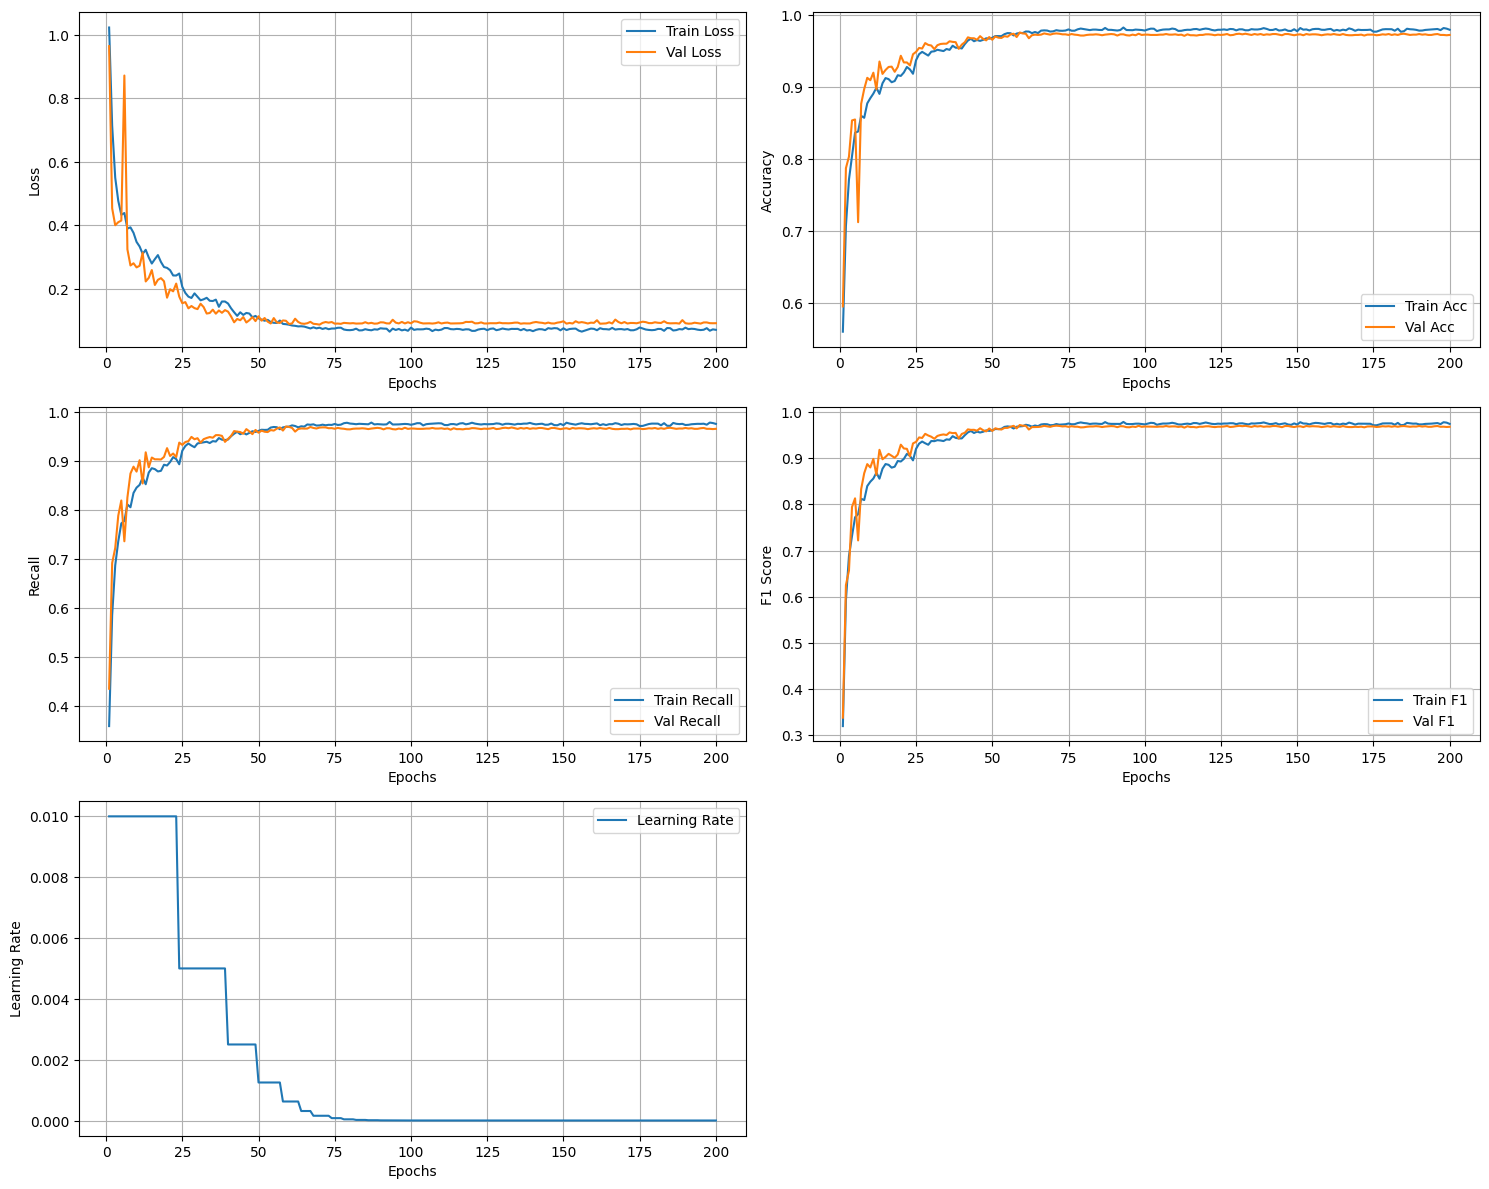

Time taken: 00:14:41.48


In [5]:
start = time.time()

dataset_path = '../../data/datasets/action_images_dataset_v1.0'

num_epochs = 200
num_classes = 4
batch_size = 64
learning_rate = 0.01  # starting with higher lr than previously
val_size = 0.2
test_size = 0.1
seed = 42

model, loaders, class_names = train_net(
    num_epochs=num_epochs, 
    dataset_path=dataset_path, 
    num_classes=num_classes, 
    batch_size=batch_size, 
    lr=learning_rate,
    val_size=val_size,
    test_size=test_size,
    random_state=seed
)

end = time.time()
print_time_taken(start, end)

# Pokretanje na test skupu i komentar

**Iako je dodato još slojeva i arhitektura učinjena složenijom nego u prvoj verziji CNN-a, rezutati se nisu mnogo promenili, udaramo u zid od oko ~97% uspešnosti modela i mogli smo komotno da stanemo s treniranjem dosta ranije, čak i pre 100. epohe. Takođe, ovde deluje da model ima tendenciju da krene ka prilagođavanju, ali taman tu negde stane sa napretkom na trening skupu, tako da deluje da se nije preprilagodio (pisano pre puštanja provere na test skupu).** 

**Sada model daje zaista sjajne rezultate na test skupu ako gledamo njihovu sličnost sa rezultatima na trening, odnosno validacionom skupu. Vrednosti posmatranih metrika su maltene identične, a čak i nešto bolje. Ovo smo se i nadali da ćemo postići, tj. da će se CNN-ovi pokazati kao dobri generalizatori, a u ovom slučaju odlični, jer radi bolje na test skupu, nego na validacionom.**

Test accuracy: 0.9732
Test recall: 0.9727
Test F1 score: 0.9714

Classification report:
              precision    recall  f1-score   support

    backhand       0.95      0.95      0.95       190
    forehand       0.96      0.96      0.96       230
       other       0.98      0.98      0.98       615
       serve       0.99      1.00      1.00       159

    accuracy                           0.97      1194
   macro avg       0.97      0.97      0.97      1194
weighted avg       0.97      0.97      0.97      1194



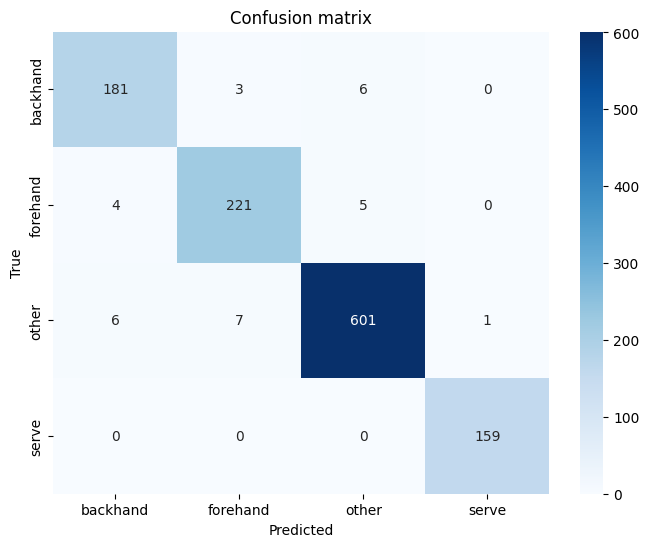

In [6]:
model.eval()

all_preds_test = []
all_labels_test = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    for inputs, labels in loaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds_test.extend(preds.cpu().numpy())
        all_labels_test.extend(labels.cpu().numpy())

test_acc = accuracy_score(all_labels_test, all_preds_test)
test_recall = recall_score(all_labels_test, all_preds_test, average='macro')
test_f1 = f1_score(all_labels_test, all_preds_test, average='macro')

print(f"Test accuracy: {test_acc:.4f}")
print(f"Test recall: {test_recall:.4f}")
print(f"Test F1 score: {test_f1:.4f}")


print("\nClassification report:")
print(classification_report(all_labels_test, all_preds_test, target_names=class_names))

cm = confusion_matrix(all_labels_test, all_preds_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [7]:
torch.save(model.state_dict(), '../../models/09_cnn_2_relabeled_data_200ep.pth')
torch.save(model, '../../models/09_cnn_2_relabeled_data_200ep_full.pth')